In [1]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from scipy.stats import rv_continuous
from scipy.stats.sampling import NumericalInverseHermite

In [2]:
RNG = int | np.random.Generator | np.random.RandomState


# Generate pseudo-random samples from a continuous distribution by Hermite interpolation
# based inversion of the CDF (HINV).
def _sample_distribution_hinv(
    dist: "scipy.stats.rv_continuous_frozen",
    size: int | tuple[int, ...] | None,
    random_state: RNG | None,
) -> np.ndarray[np.float_]:
    """ """
    hinv = NumericalInverseHermite(
        dist,
        domain=dist.support(),
        u_resolution=1e-10,
        random_state=random_state,
    )
    return hinv.rvs(size=size)


# Distribution of the multi-looked sample interferometric phase, given the coherence of
# the data-generating process and number of IID looks. Assumes that components of the
# scattering matrix were jointly circular Gaussian distributed. 
class _SamplePhase(rv_continuous):
    def _argcheck(
        self,
        coherence: np.ndarray[np.floating],
        nlooks: np.ndarray[np.floating],
    ) -> np.ndarray[np.bool_]:
        """ """
        return (coherence >= 0.0) & (coherence <= 1.0) & (nlooks >= 1.0)

    def _pdf(
        self,
        x: np.ndarray[np.floating],
        coherence: np.ndarray[np.floating],
        nlooks: np.ndarray[np.floating],
    ) -> np.ndarray[np.float_]:
        """ """
        coh_sq = coherence ** 2

        beta = coherence * np.cos(x)
        beta_sq = beta ** 2

        c1 = np.power(1.0 - coh_sq, nlooks)
        c2 = sc.gamma(nlooks + 0.5) * c1 * beta
        c3 = 2.0 * np.sqrt(np.pi) * sc.gamma(nlooks)
        c4 = np.power(1.0 - beta_sq, nlooks + 0.5)
        c5 = c1 / (2.0 * np.pi)
        c6 = sc.hyp2f1(nlooks, 1.0, 0.5, beta_sq)

        return c2 / (c3 * c4) + c5 * c6

    def _rvs(
        self,
        coherence: np.ndarray[np.floating],
        nlooks: np.ndarray[np.floating],
        size: int | tuple[int, ...] | None,
        random_state: RNG | None,
    ) -> np.ndarray[np.float_]:
        """ """
        dist = self(coherence=coherence, nlooks=nlooks)
        return _sample_distribution_hinv(dist, size, random_state)


SamplePhase = _SamplePhase(a=-np.pi, b=np.pi, name="SamplePhase")


# Distribution of the multi-looked sample interferometric coherence, given the coherence
# of the data-generating process and number of IID looks (must be >= 2). Assumes that
# components of the scattering matrix were jointly circular Gaussian distributed.
class _SampleCoherence(rv_continuous):
    def _argcheck(
        self,
        coherence: np.ndarray[np.floating],
        nlooks: np.ndarray[np.floating],
    ) -> np.ndarray[np.bool_]:
        """ """
        return (coherence >= 0.0) & (coherence <= 1.0) & (nlooks >= 2.0)
    
    def _pdf(
        self,
        x: np.ndarray[np.floating],
        coherence: np.ndarray[np.floating],
        nlooks: np.ndarray[np.floating],
    ) -> np.ndarray[np.float_]:
        """ """
        coh_sq = coherence ** 2
        x_sq = x ** 2
        
        c1 = 2.0 * (nlooks - 1.0) * (1.0 - coh_sq) ** nlooks
        c2 = x * (1.0 - x_sq) ** (nlooks - 2.0)
        c3 = sc.hyp2f1(nlooks, nlooks, 1.0, coh_sq * x_sq)
        
        return c1 * c2 * c3

    def _rvs(
        self,
        coherence: np.ndarray[np.floating],
        nlooks: np.ndarray[np.floating],
        size: int | tuple[int, ...] | None,
        random_state: RNG | None,
    ) -> np.ndarray[np.float_]:
        """ """
        dist = self(coherence=coherence, nlooks=nlooks)
        return _sample_distribution_hinv(dist, size, random_state)


SampleCoherence = _SampleCoherence(a=0.0, b=1.0, name="SampleCoherence")


def sample_coherence_dolphin(
    coherence: float, 
    nlooks: tuple[int, int], 
    size: int,
    random_state: RNG | None = None,
) -> np.ndarray[np.float_]:
    """ """
    # Simulate samples of single-look interferometric sample phase.
    dist = SamplePhase(coherence, nlooks=1.0)
    size = (size,) + nlooks
    phi = dist.rvs(size, random_state=random_state)

    # Generate unit-magnitude complex vectors with the given phase.
    z = np.cos(phi) + 1j * np.sin(phi)

    # Estimate sample coherence as in dolphin.
    return np.abs(np.mean(z, axis=(1, 2)))

/var/folders/hg/dlrby3gx31l3g9bfdzzrbv700000gq/T/ipykernel_38764/847738219.py:95: RuntimeWarning: invalid value encountered in multiply
  return c1 * c2 * c3


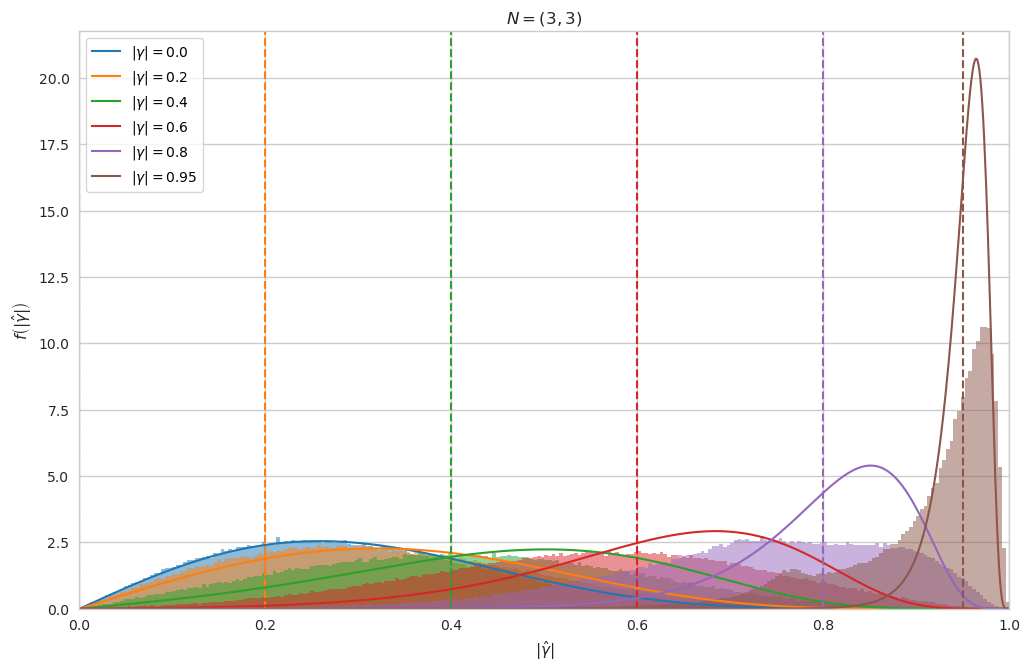

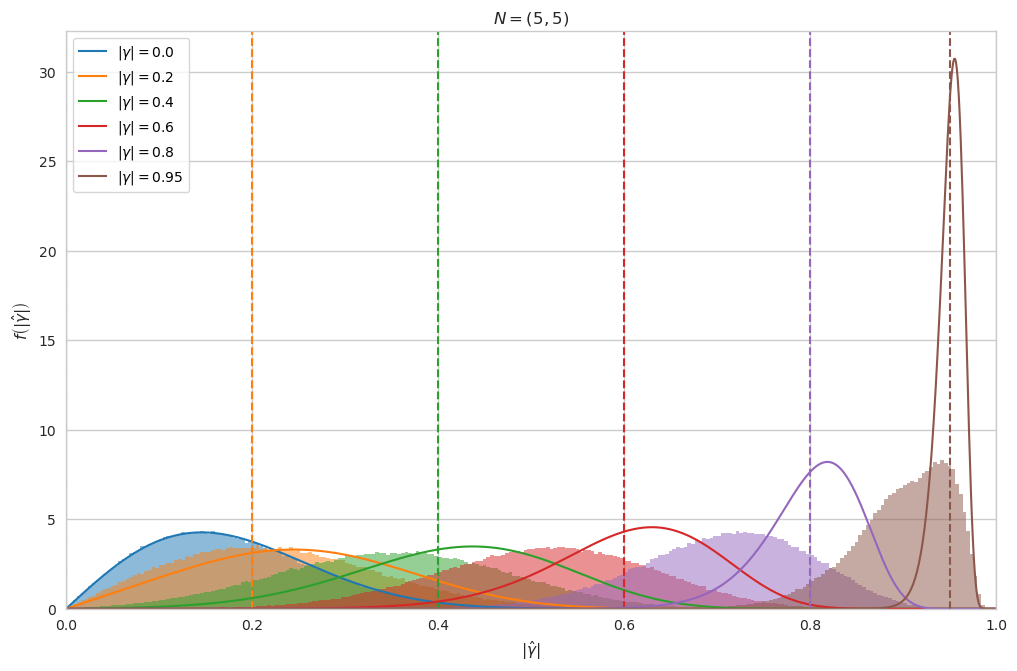

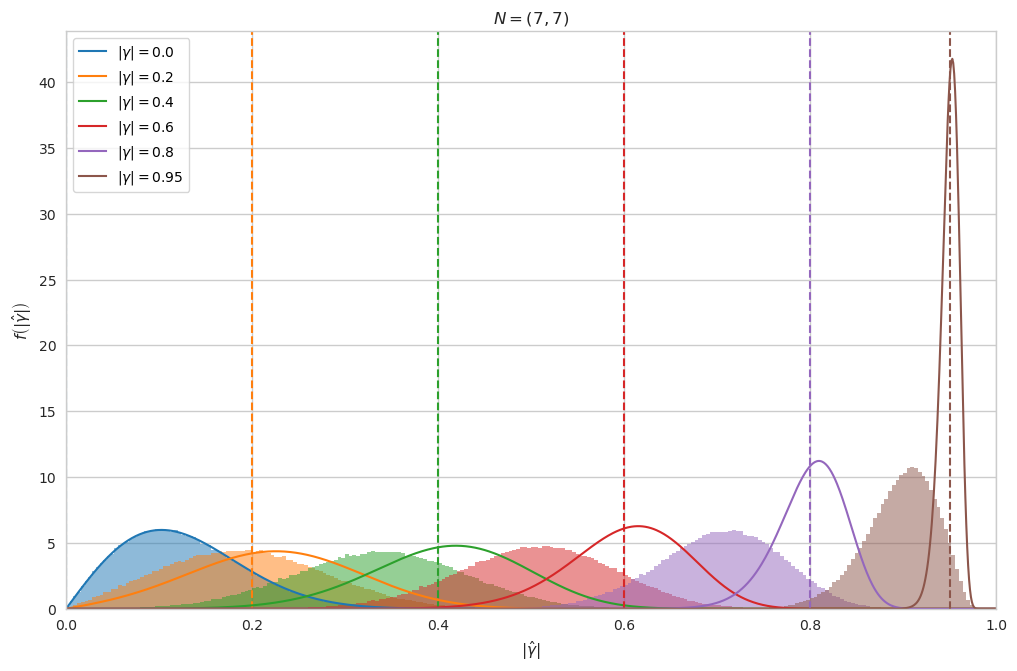

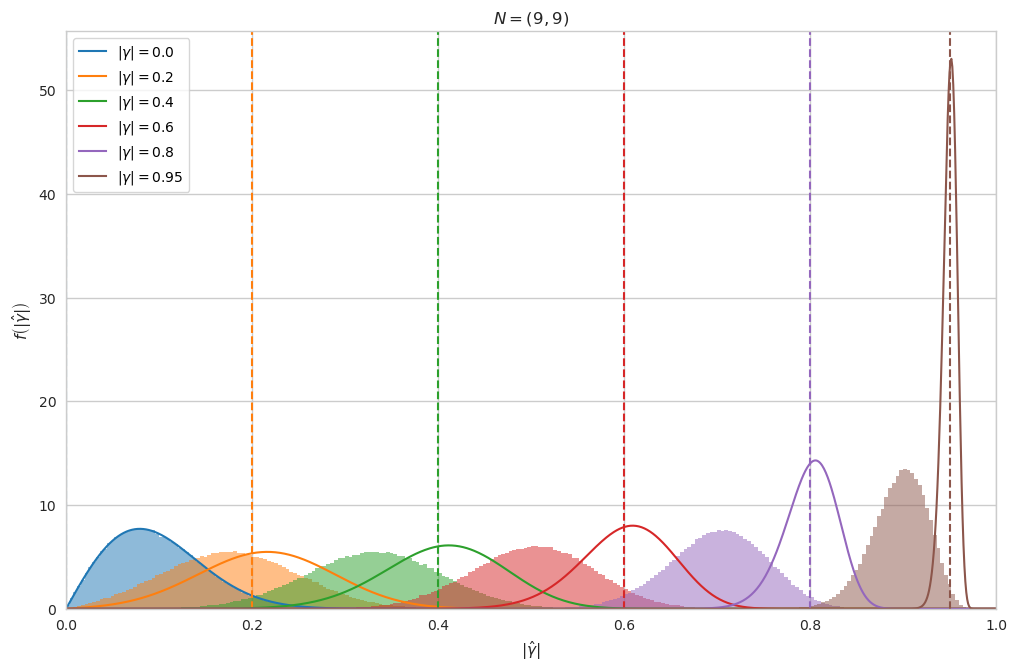

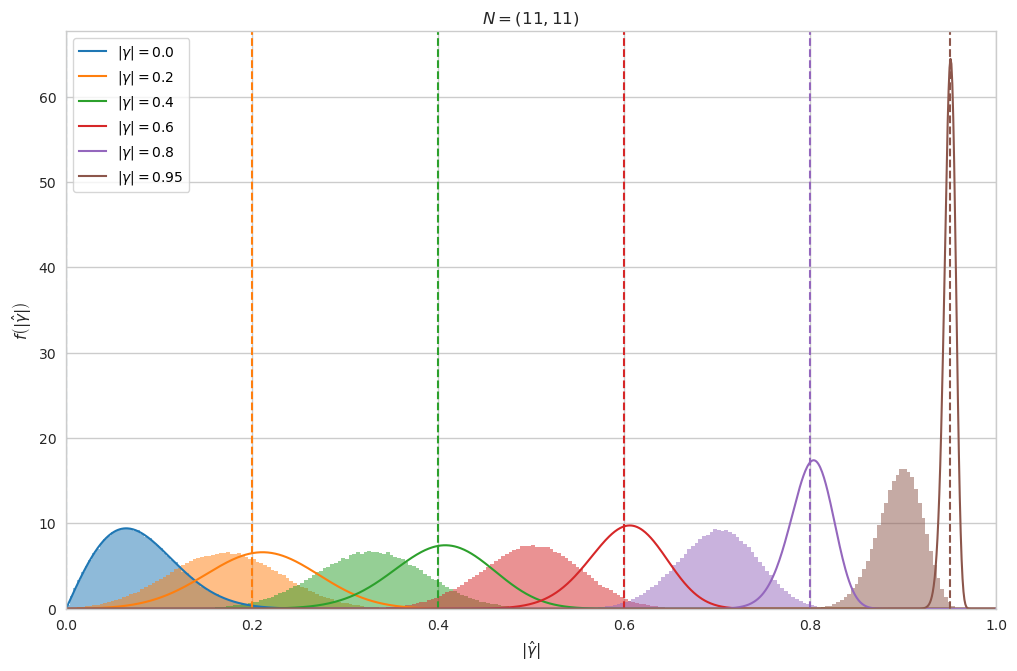

In [3]:
palette = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

plt.close("all")
for nlooks in [(3, 3), (5, 5), (7, 7), (9, 9), (11, 11)]:
    with plt.style.context("seaborn-notebook"), plt.style.context("seaborn-whitegrid"):
        fig, ax = plt.subplots(figsize=(12, 7.5))

    ax.set_title(rf"$N = {nlooks}$")
    for coherence, color in zip([0.0, 0.2, 0.4, 0.6, 0.8, 0.95], palette):
        dist = SampleCoherence(coherence=coherence, nlooks=np.prod(nlooks))

        # Plot PDF of sample coherence.
        gamma_hat = np.linspace(0.0, 1.0, num=1001)
        f = dist.pdf(gamma_hat)
        ax.plot(gamma_hat, f, color=color, label=rf"$|\gamma| = {coherence}$")

        # Plot histogram of dolphin coherence.
        samples = sample_coherence_dolphin(coherence, nlooks, size=1<<18)
        ax.hist(samples, bins=250, range=[0.0, 1.0], density=True, color=color, alpha=0.5)

        # Plot true coherence.
        ax.axvline(coherence, color=color, linestyle="--")

    ax.set_xlim([0.0, 1.0])
    ax.set_xlabel(r"$|\hat{\gamma}|$")
    ax.set_ylabel(r"$f\left(|\hat{\gamma}|\right)$")
    ax.legend()

plt.show()